<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/GNN_Graph_Attention_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Attention Networks
> Chapter 2 of the [Graph Neural Network Course](https://github.com/mlabonne/Graph-Neural-Network-Course)

In [1]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Dataset

PubMed. Это набор данных из 19 717 научных публикаций о диабете из базы данных PubMed из трёх категорий. Признаки узла — взвешенные по TF-IDF векторы слов из словаря на 500 уникальных слов.

In [2]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Pubmed")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...


Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


Done!


In [3]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 0


# Plot dataset

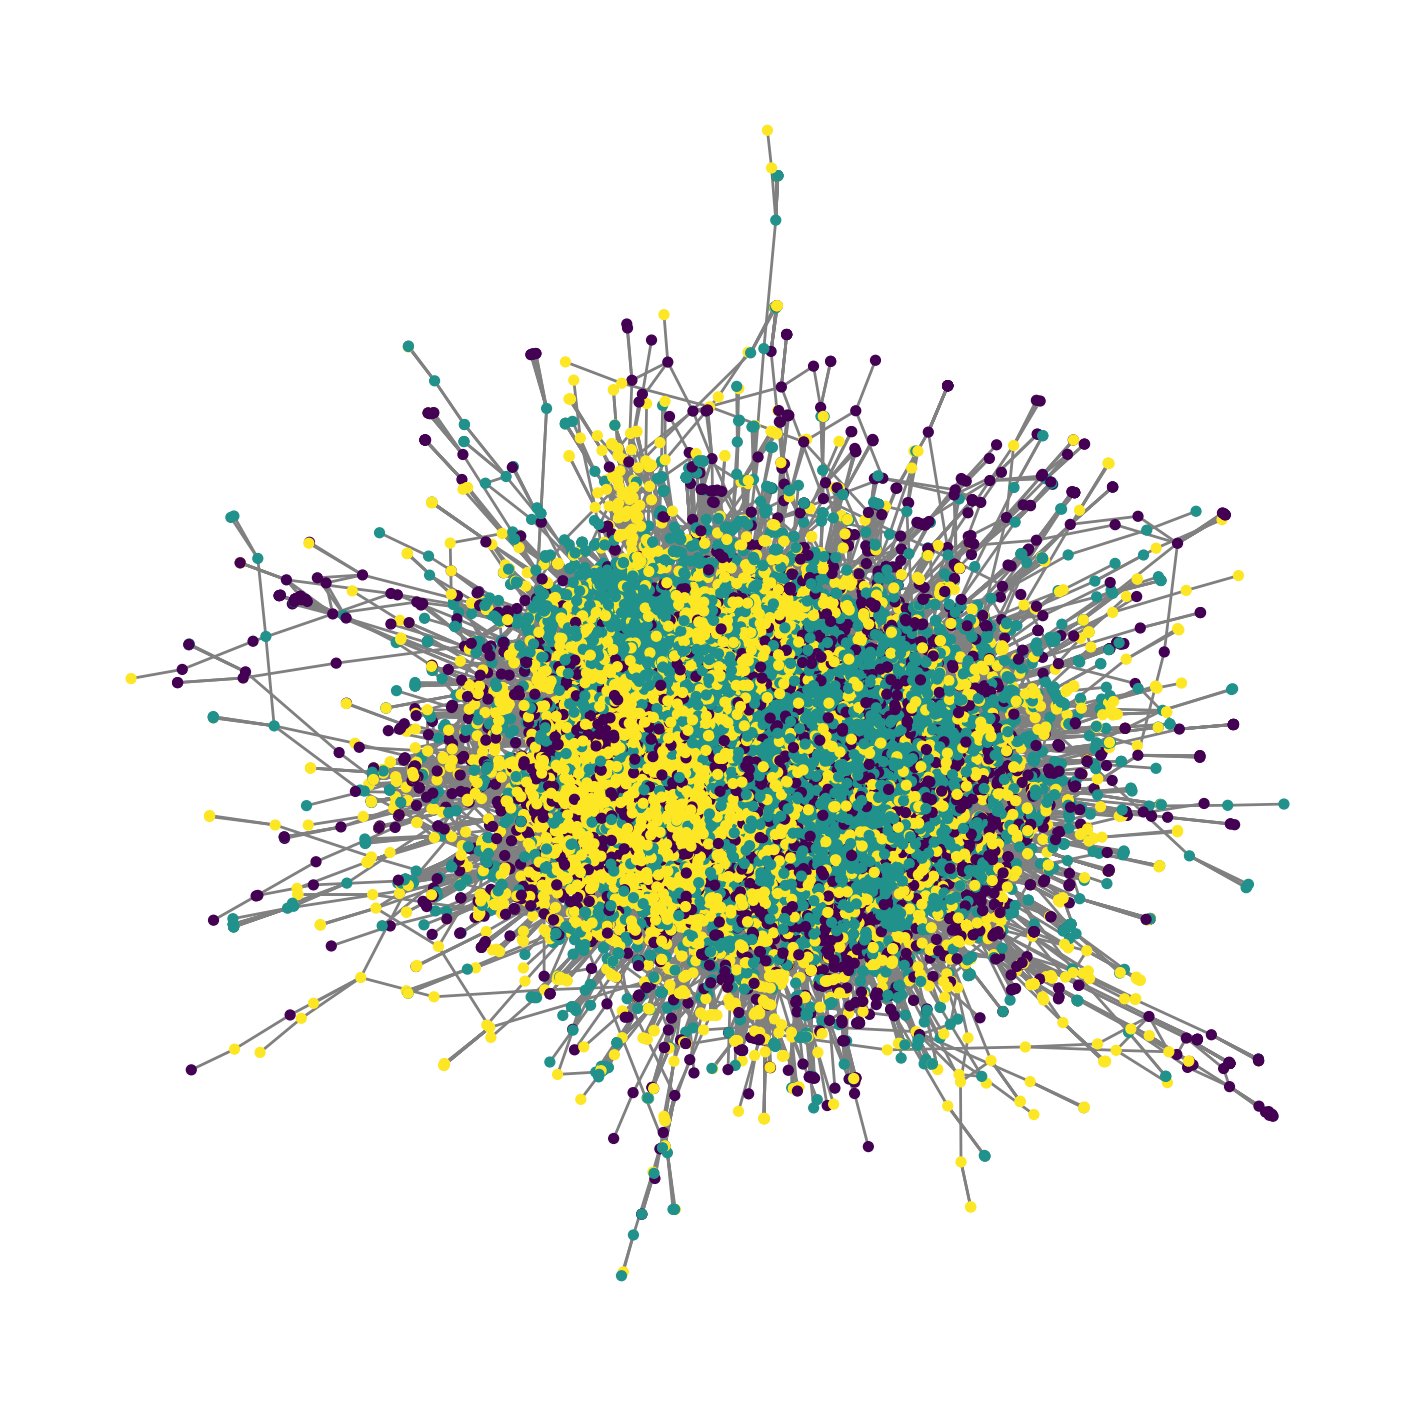

In [4]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

# Plot node degrees

<BarContainer object of 82 artists>

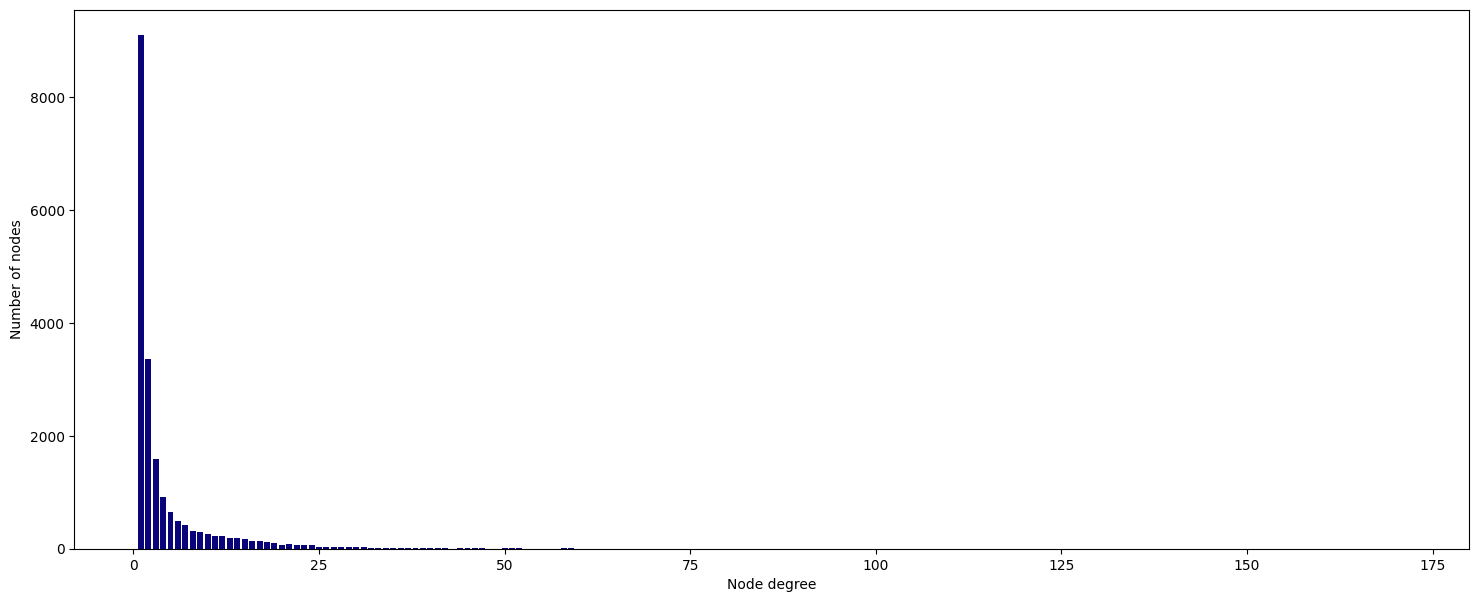

In [5]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

# Implement GAT vs. GCN

In [6]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 50

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Train GCN

In [7]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(500, 16)
  (gcn2): GCNConv(16, 3)
)
Epoch   0 | Train Loss: 1.101 | Train Acc:  30.00% | Val Loss: 1.10 | Val Acc: 40.60%
Epoch  10 | Train Loss: 0.928 | Train Acc:  88.33% | Val Loss: 1.00 | Val Acc: 66.00%
Epoch  20 | Train Loss: 0.718 | Train Acc:  90.00% | Val Loss: 0.86 | Val Acc: 70.60%
Epoch  30 | Train Loss: 0.523 | Train Acc:  95.00% | Val Loss: 0.75 | Val Acc: 70.00%
Epoch  40 | Train Loss: 0.322 | Train Acc:  98.33% | Val Loss: 0.70 | Val Acc: 73.80%
Epoch  50 | Train Loss: 0.292 | Train Acc:  95.00% | Val Loss: 0.66 | Val Acc: 73.20%
Epoch  60 | Train Loss: 0.255 | Train Acc:  96.67% | Val Loss: 0.64 | Val Acc: 75.00%
Epoch  70 | Train Loss: 0.200 | Train Acc:  98.33% | Val Loss: 0.66 | Val Acc: 72.80%
Epoch  80 | Train Loss: 0.158 | Train Acc:  98.33% | Val Loss: 0.64 | Val Acc: 71.60%
Epoch  90 | Train Loss: 0.152 | Train Acc: 100.00% | Val Loss: 0.66 | Val Acc: 74.00%
Epoch 100 | Train Loss: 0.162 | Train Acc:  98.33% | Val Loss: 0.65 | Val Acc: 75

# Train GAT

In [8]:
%%time

# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train
train(gat, data)

# Test
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(500, 8, heads=8)
  (gat2): GATv2Conv(64, 3, heads=1)
)
Epoch   0 | Train Loss: 1.099 | Train Acc:  33.33% | Val Loss: 1.08 | Val Acc: 41.60%
Epoch  10 | Train Loss: 0.854 | Train Acc:  90.00% | Val Loss: 0.94 | Val Acc: 72.80%
Epoch  20 | Train Loss: 0.576 | Train Acc:  91.67% | Val Loss: 0.77 | Val Acc: 73.40%
Epoch  30 | Train Loss: 0.346 | Train Acc:  95.00% | Val Loss: 0.65 | Val Acc: 74.80%
Epoch  40 | Train Loss: 0.212 | Train Acc:  96.67% | Val Loss: 0.58 | Val Acc: 76.60%
Epoch  50 | Train Loss: 0.141 | Train Acc:  96.67% | Val Loss: 0.57 | Val Acc: 77.60%
Epoch  60 | Train Loss: 0.100 | Train Acc: 100.00% | Val Loss: 0.56 | Val Acc: 77.40%
Epoch  70 | Train Loss: 0.076 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 77.00%
Epoch  80 | Train Loss: 0.066 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 77.60%
Epoch  90 | Train Loss: 0.055 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 77.40%
Epoch 100 | Train Loss: 0.054 | Train Acc: 100.00% | Val Los

# t-SNE plots

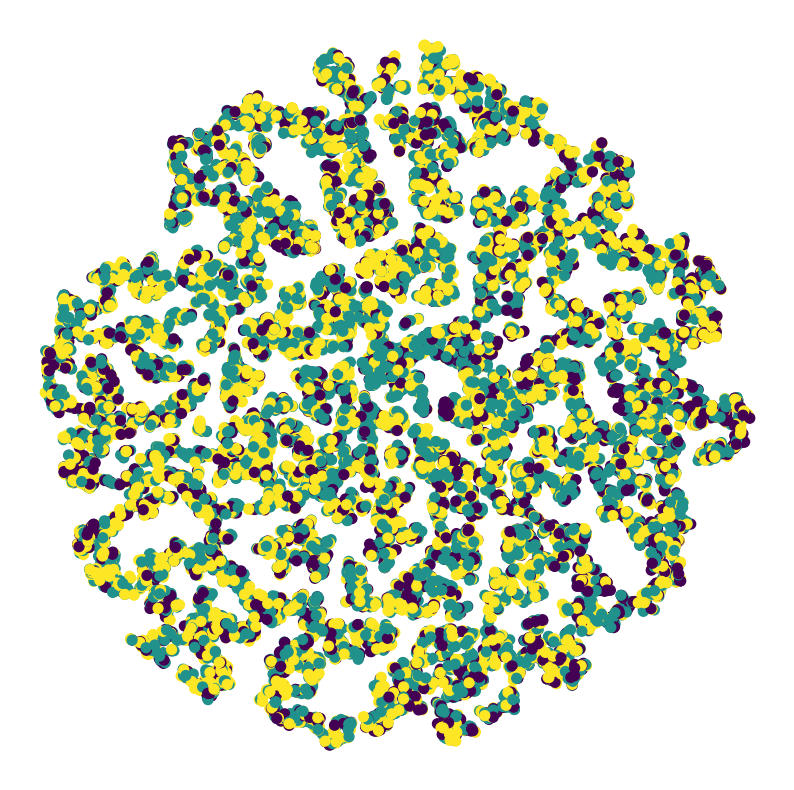

In [9]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

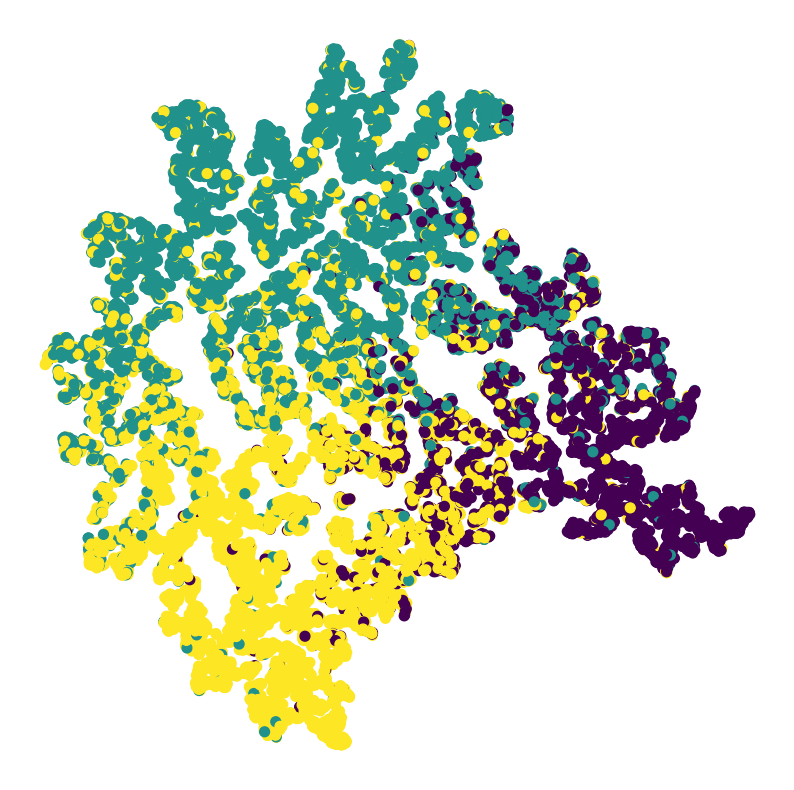

In [10]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()